In [1]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import os
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large as deeplab

In [2]:
fd = "/home/jupyter/ai_font/data/exp0717/train_seg/raw_assembled"

In [3]:
class myDS(Dataset):
    def __init__(self, fd):
        self.path_list = []
        for root, dirs, files in os.walk(fd):
            for file in files:
                if file.endswith('.png') & ("checkpoint" not in file):
                    image_path = os.path.join(root, file)
                    label_root = root.replace("raw_assembled","raw_label")
                    label_file = file.replace(".png",".npy")
                    label_path = os.path.join(label_root, label_file)
                    self.path_list.append((image_path,label_path,))
        self.transforms = transforms.Compose([
                transforms.ToTensor(),  # Rescales to [0.0, 1.0]
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self, idx):
        image_path, label_path = self.path_list[idx]
        image = Image.open(image_path).convert("RGB")
        mask = np.load(label_path)
        
        return self.transforms(image), torch.from_numpy(mask)

In [4]:
def calculate_accuracy(preds, targets):

    # Convert predictions to class labels by taking the argmax along the class dimension
    pred_labels = torch.argmax(preds, dim=1)
    target_labels = torch.argmax(targets, dim=1)
    
    # Check if the predicted labels are equal to the target labels
    correct = (pred_labels == target_labels).float()
    
    # Calculate the accuracy
    accuracy = correct.sum() / correct.numel()
    
    return accuracy.item() * 100  # Convert to percentage

In [5]:
ds = myDS("/home/jupyter/ai_font/data/exp0717/train_seg/raw_assembled")
dl = DataLoader(ds, batch_size=32, shuffle=True)

In [6]:
model = deeplab(weights_backbone="DEFAULT", num_classes=4)
model = model.cuda()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
epoch = 100

In [ ]:
pbar = tqdm(range(epoch))
model.train()
for _ in pbar:
    for data in dl:
        optimizer.zero_grad()
        x, y = data
        x = x.cuda()
        y = y.cuda()
        pred = model(x)
        loss = criterion(pred['out'], y)
        loss.backward()
        optimizer.step()
        acc = calculate_accuracy(pred['out'], y)
        pbar.set_postfix(acc=acc)

  0%|          | 0/100 [1:10:01<?, ?it/s, acc=98.9]


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1, 1])

In [10]:
torch.save(model.state_dict(), "proto.pth")

In [ ]:
[a for a in ds.path_list if ("-checkpoint" in a[0]) & (("-checkpoint" in a[1]))]

In [11]:
a = ds[0]

In [13]:
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [16]:
model.eval()
b = model(a[0].unsqueeze(0).cuda())

In [18]:
c = torch.argmax(b['out'], dim=1).detach().cpu().numpy()

In [19]:
c.shape

(1, 520, 520)

In [48]:
img = Image.open(ds.path_list[0][0])
npimg = np.array(img)

In [49]:
npimg[np.where(c[0]!=2)] = 255

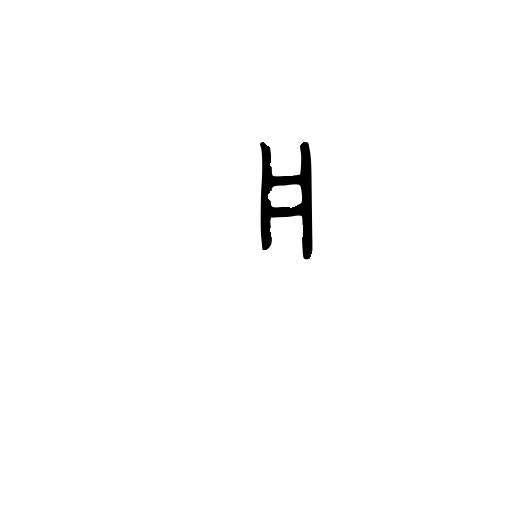

In [50]:
Image.fromarray(npimg)

In [57]:
img = Image.open("/home/jupyter/ai_font/data/test/pngs/갊.png").resize((520,520), Image.BILINEAR).convert("RGB")

In [61]:
output = model(ds.transforms(img).cuda().unsqueeze(0))

In [63]:
mapp = torch.argmax(b['out'], dim=1).detach().cpu().numpy()

In [74]:
npimg = np.array(img)
npimg[np.where(mapp[0]!=0)] = 255

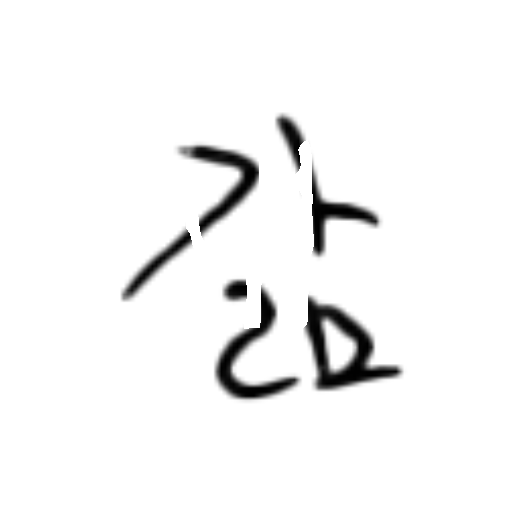

In [75]:
Image.fromarray(npimg)

In [66]:
mapp

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])